## import library  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import matplotlib.pyplot as plt

## read data

In [2]:
path_data_istabul = 'data/Istanbul Weather Data normalization.csv'

df = pd.read_csv(path_data_istabul)
print(df.shape)
df.head(10)

(3896, 7)


,DateTime,Rain,MaxTemp,MinTemp,AvgWind,AvgHumidity,AvgPressure
0,2009-01-01,0.005476,0.200,0.225806,0.148148,0.877193,0.760870
1,2009-01-02,0.106667,0.175,0.193548,0.185185,0.859649,0.630435
2,2009-01-03,0.001905,0.200,0.258065,0.259259,0.947368,0.630435
3,2009-01-04,0.069286,0.200,0.258065,0.129630,0.947368,0.478261
4,2009-01-05,0.102857,0.200,0.258065,0.240741,1.000000,0.500000
5,2009-01-06,0.064524,0.200,0.258065,0.370370,0.982456,0.478261
6,2009-01-07,0.005476,0.250,0.225806,0.166667,0.842105,0.652174
7,2009-01-08,0.072857,0.275,0.193548,0.185185,0.842105,0.695652
8,2009-01-09,0.030000,0.150,0.161290,0.388889,0.754386,0.891304
9,2009-01-10,0.000000,0.200,0.161290,0.092593,0.736842,0.782609


In [3]:
def re_organize(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index("DateTime",inplace=True)
    return df
df= re_organize(df)
df

,Rain,MaxTemp,MinTemp,AvgWind,AvgHumidity,AvgPressure
DateTime,,,,,,
2009-01-01,0.005476,0.200,0.225806,0.148148,0.877193,0.760870
2009-01-02,0.106667,0.175,0.193548,0.185185,0.859649,0.630435
2009-01-03,0.001905,0.200,0.258065,0.259259,0.947368,0.630435
2009-01-04,0.069286,0.200,0.258065,0.129630,0.947368,0.478261
2009-01-05,0.102857,0.200,0.258065,0.240741,1.000000,0.500000
...,...,...,...,...,...,...
2019-08-28,0.000000,0.750,0.903226,0.407407,0.368421,0.500000
2019-08-29,0.000000,0.750,0.870968,0.333333,0.421053,0.521739
2019-08-30,0.011905,0.725,0.870968,0.370370,0.403509,0.500000


In [4]:
lookback = 120
cols_target = ['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure']
df_train_transformed = df.reset_index(drop=True)
x = []
t = []
for i in range(1, len(df)-lookback-1):
    x.append(df_train_transformed.loc[i:i+lookback-1,cols_target].values)
    t.append(df_train_transformed.loc[i+lookback,cols_target].values.tolist())
X_train = np.array(x).reshape(-1,lookback,len(cols_target))
y_train = np.array(t)
print("X_train shape",X_train.shape)
print("y_train shape",y_train.shape)

X_train shape (3774, 120, 6)
y_train shape (3774, 6)


In [5]:
#データの分割
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [6]:
X_train.shape

(3396, 120, 6)

## model(TCN) 
https://qiita.com/top4hac/items/2a044b41c69f3c8802ef

In [7]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [8]:
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [9]:
from sklearn.utils import shuffle
import numpy as np
import torch
import torch.optim as optimizers

np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 200
batch_size = 256
n_batches_train = X_train.shape[0] // batch_size + 1
n_batches_val = X_val.shape[0] // batch_size + 1
learning_rate = 0.01

input_size = 6
hidden_size = 100
num_layers = 1

num_classes = 6

hist = {'loss': [], 'val_loss': []}
es = EarlyStopping(patience=10, verbose=1)

model=TemporalConvNet(120,[400,300,200,100,50,1],kernel_size=3, dropout=0.2)

# mse=nn.L1Loss()
optimizer = optimizers.Adam(model.parameters(),lr=0.001)
# optimizer = optimizers.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)
#                             lr=0.001),
#                             betas=(0.9, 0.999), amsgrad=True)


criterion = torch.nn.MSELoss()    # mean-squared error for regression
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
model

TemporalConvNet(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(120, 400, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(400, 400, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(120, 400, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): Chomp1d()
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv1d(400, 400, kernel_size=(3,), stride=(1,), padding=(2,))
        (5): Chomp1d()
        (6): ReLU()
        (7): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(120, 400, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(400, 300, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (chomp1): Chomp1

In [10]:
preds_0 = 0
t_0 = 0

def train_step(x, t):

    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.train()
    preds = model(x).to(device)
#     print(preds.shape,t.shape)
    loss = criterion(preds.view(-1),t.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

def val_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.eval()
    preds = model(x)
    loss = criterion(preds.view(-1), t.view(-1))

    return loss, preds

## train the TCN

In [11]:
for epoch in range(num_epochs):
    train_loss = 0.
    val_loss = 0.
    x_, y_ = shuffle(X_train, y_train)

    for batch in range(n_batches_train):
        start = batch * batch_size
        end = start + batch_size
#         print(start, end)
#         print(x_.shape,y_.shape)
        loss, _ = train_step(x_[start:end], y_[start:end])
        train_loss += loss.item()

    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = val_step(X_val[start:end], y_val[start:end])
        val_loss += loss.item()

    train_loss /= n_batches_train
    val_loss /= n_batches_val

    hist['loss'].append(train_loss)
    hist['val_loss'].append(val_loss)

    print('epoch: {}, loss: {:.3}, val_loss: {:.3}'.format(
        epoch+1,
        train_loss,
        val_loss
    ))

    if es(val_loss):
        break

epoch: 1, loss: 0.143, val_loss: 0.101
epoch: 2, loss: 0.0484, val_loss: 0.0248
epoch: 3, loss: 0.0253, val_loss: 0.0234
epoch: 4, loss: 0.0182, val_loss: 0.0136
epoch: 5, loss: 0.0136, val_loss: 0.0117
epoch: 6, loss: 0.0127, val_loss: 0.0113
epoch: 7, loss: 0.0124, val_loss: 0.0111
epoch: 8, loss: 0.0118, val_loss: 0.0102
epoch: 9, loss: 0.011, val_loss: 0.0101
epoch: 10, loss: 0.0107, val_loss: 0.00979
epoch: 11, loss: 0.0103, val_loss: 0.00958
epoch: 12, loss: 0.00988, val_loss: 0.00923
epoch: 13, loss: 0.00946, val_loss: 0.00887
epoch: 14, loss: 0.00916, val_loss: 0.00874
epoch: 15, loss: 0.00915, val_loss: 0.0087
epoch: 16, loss: 0.00866, val_loss: 0.00899
epoch: 17, loss: 0.00862, val_loss: 0.00847
epoch: 18, loss: 0.00846, val_loss: 0.00827
epoch: 19, loss: 0.00794, val_loss: 0.00808
epoch: 20, loss: 0.00771, val_loss: 0.00803
epoch: 21, loss: 0.0077, val_loss: 0.00846
epoch: 22, loss: 0.00767, val_loss: 0.00792
epoch: 23, loss: 0.00737, val_loss: 0.00792
epoch: 24, loss: 0.007

## predict rainfall, temp,wind,humidity and pressure

In [12]:
model.eval()
x_ = torch.Tensor(X_val).to(device)
preds_val = model(x_).data.cpu().numpy()
preds_val=preds_val.reshape(-1,6)
preds_val.shape

(378, 6)

In [13]:
df_preds_val = pd.DataFrame(preds_val,columns=['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure'])
df_val = pd.DataFrame(y_val, columns=['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure'])

In [14]:
df_preds_val

,Rain,MaxTemp,MinTemp,AvgWind,AvgHumidity,AvgPressure
0,0.004854,0.797820,0.950028,0.397282,0.347557,0.471503
1,0.004339,0.768312,0.919412,0.348355,0.407202,0.451259
2,0.010310,0.764584,0.899807,0.291439,0.451170,0.465149
3,0.008058,0.786468,0.930395,0.364381,0.410402,0.475797
4,0.009955,0.799310,0.951439,0.411398,0.334208,0.449397
...,...,...,...,...,...,...
373,0.000000,0.815473,0.920761,0.392527,0.410560,0.502272
374,0.024677,0.776460,0.897783,0.403900,0.363248,0.502360
375,0.015221,0.714903,0.845381,0.365514,0.434589,0.504332
376,0.010848,0.708977,0.836686,0.298279,0.435656,0.520360


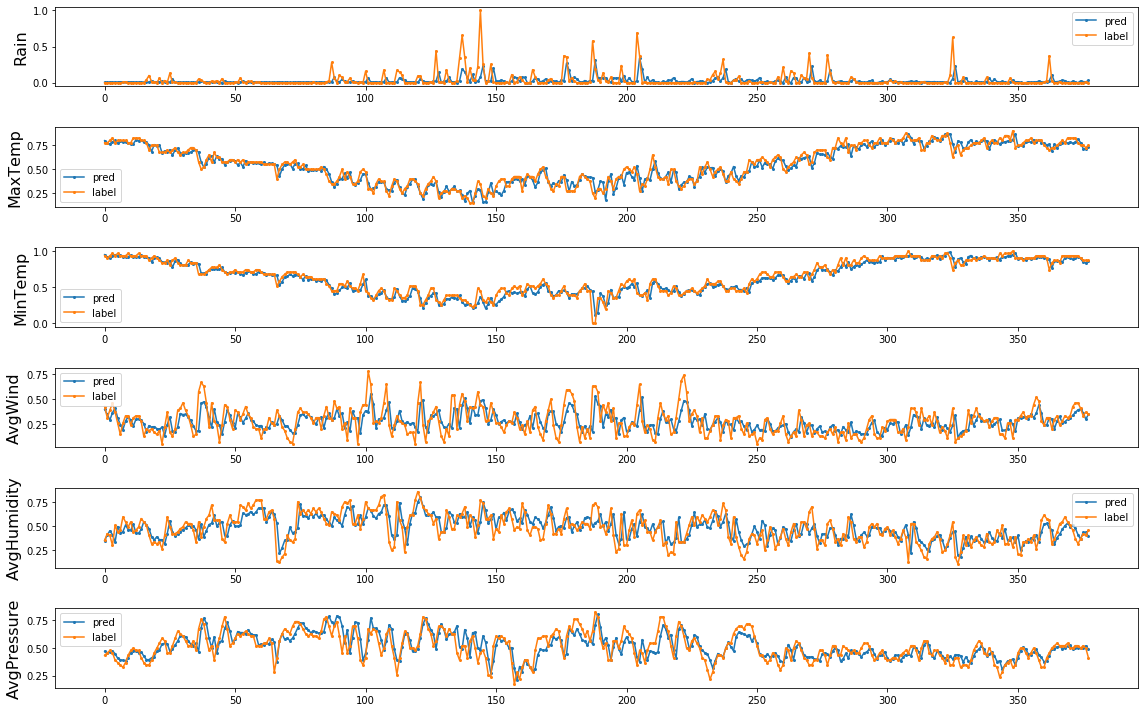

In [15]:
import matplotlib.pyplot as plt

col_vals = ['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure']
nrows = len(col_vals)
width = 16
height = 10

fig, axs = plt.subplots(nrows, 1, figsize=(width, height), facecolor='w')
axs = axs.ravel()
for i, col in enumerate(col_vals):
    axs[i].plot(df_preds_val.index, df_preds_val[col], marker='o', markersize=2, label='pred')
    axs[i].plot(df_val.index, df_val[col], marker='o', markersize=2, label='label')
    axs[i].set_ylabel(col, fontsize=16)
    axs[i].legend()

plt.tight_layout()
plt.show()

## check laerning progress

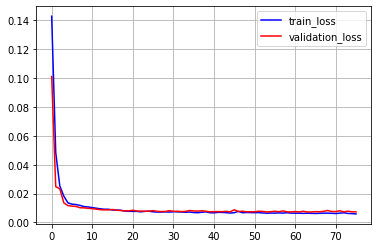

In [16]:
plt.plot(range(len(hist["loss"])),hist["loss"],
         color='blue', linestyle='-', label='train_loss')
plt.plot(range(len(hist["val_loss"])), hist["val_loss"],
         color='r', linestyle='-', label='validation_loss')

plt.legend()
plt.grid()